# First tests on Compressed Sensing
The aim of this notebook is to demonstrate the use of compressed sensing.
Tutorial from http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/

# Scope
"Compressed sensing" refers to a technique that can be used to reconstruct a signal from a smaller number of samples than would be required using traditional methods. This technique is particularly well suited to signals that are known to be sparse in the frequency domain, as is the case for NMR spectra.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Import matplotlib style for HQS
import HQStyle
HQStyle.import_all()

#plt.rcParams['figure.figsize'] = (10, 5)

# Poission Distribution
The formula for probability mass function for a Poisson distribution, with parameter $\lambda > 0$ is:
\begin{equation}
        P(k) = (\lambda^k)\exp(-\lambda)/k!
\end{equation}
where $\lambda$ is the rate of the Poisson distribution, and $k$ is the number of events.

The Poisson distribution is an appropriate model if the following assumptions are true:
- $k$ is the number of times an event occurs in an interval and $k$ can take values 0, 1, 2, ….
- The occurrence of one event does not affect the probability that a second event will occur. That is, events occur independently.
- The average rate at which events occur is independent of any occurrences. For simplicity, this is usually assumed to be constant, but may in practice vary with time.
- Two events cannot occur at exactly the same instant; instead, at each very small sub-interval, either exactly one event occurs, or no event occurs.

If these conditions are true, then $k$ is a Poisson random variable, and the distribution of $k$ is a Poisson distribution.

Sine-weighted Poisson gap is a non-uniform sampling (NUS) schedule that is dense at short times. This schedule has been shown to reduce reconstruction artifacts.

In [35]:
import compressed_sensing as cs

seed_value = 1
number_of_samples =64
total_number_of_indices = 100

set1 = cs.PoissonNumbers(seed_value,number_of_samples,total_number_of_indices, usenumpy=True)
set2 = cs.PoissonNumbers(seed_value,number_of_samples,total_number_of_indices, usenumpy=False)

set1 == set2

0	1	2	3	4	6	7	8	9	11	12	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	30	31	33	34	36	38	39	40	41	42	45	47	52	53	54	56	57	59	61	62	63	65	67	71	73	76	77	79	82	83	86	87	88	90	92	95	97	99	
0	1	2	3	4	5	7	8	9	10	11	12	13	14	15	16	17	19	20	21	22	23	25	26	27	30	32	33	34	35	37	39	42	43	45	46	49	51	52	54	57	59	60	61	63	64	67	69	71	72	74	75	77	79	80	81	84	87	89	92	93	95	98	99	


False

In [7]:
print(set1)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 14, 16, 18, 19, 21, 23, 24, 27, 29, 30, 32, 34, 38, 40, 45, 48, 51, 52, 56, 58, 61, 65, 67, 72, 75, 78, 81, 85, 92, 97, 99, 105, 110, 114, 121, 126, 134, 144, 150, 157, 161, 172, 181, 190, 202, 204, 209, 217, 226, 233, 241, 248, 254]


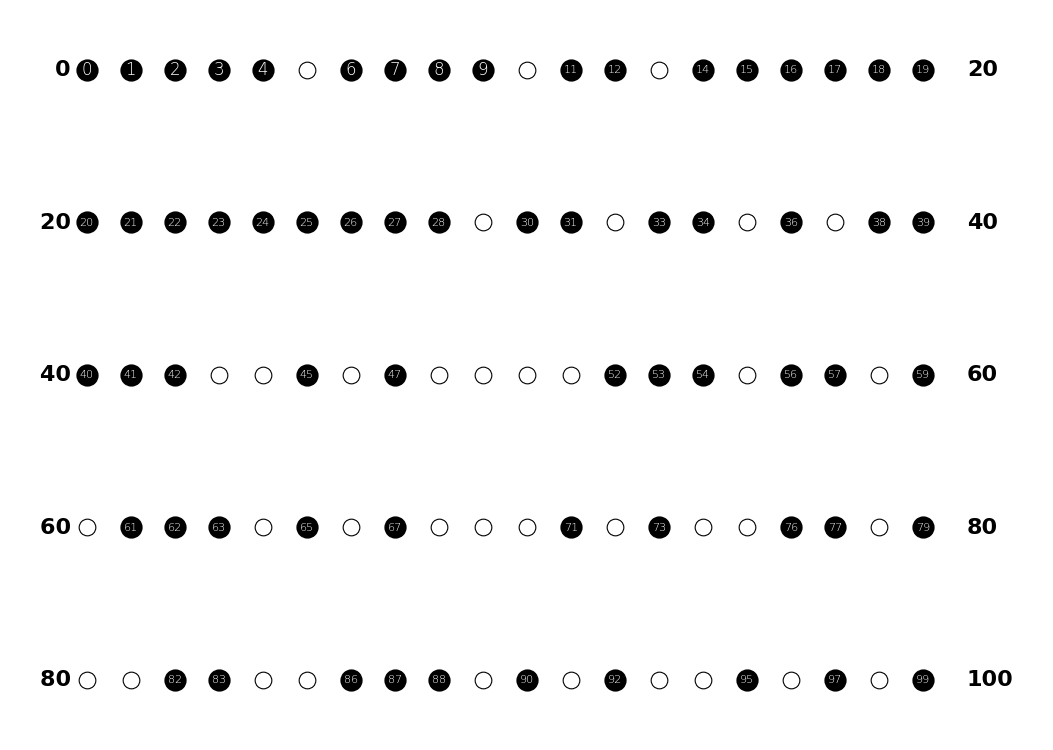

In [42]:
from turtle import color
from numpy import linspace



# to increaze the size of the markers, use the following:


#split a list into n parts

class MyPlot:
    
    def find_between(self,set1,start,end):
        return [i for i in set1 if start <= i < end]

    def split_list(self,l, n, max_value):
        divisor = max_value // n
        return [self.find_between(l,divisor*i, divisor*(i+1)) for i in range(n)]
    def subtract_list(self,l, n):
        return [x-n for x in l]

    def plot_list(self,set1, max_value, rows=5):
        splitset = self.split_list(set1, rows, max_value)
        divisor = max_value // rows
        #plt.gca().axes.get_yaxis().set_visible(False)
        plt.axis('off')
        #plt.ylim(-1,rows+1)
        for i,subset in enumerate(splitset):
            y = len(splitset)-i
            plt.plot(np.arange(0,divisor), [y]*(divisor), 'o',color='white', markeredgewidth=0.2, markeredgecolor='black', markersize=rows-2)
            plt.plot(self.subtract_list(subset,divisor*i),[y]*len(subset) , 'o',color='black', markersize=rows-2)
            #make a list of number between divisor*i and divisor*(i+1)
            
            #move the text further to the left: 
            plt.text(0,y,str(i*divisor)+"  ",fontsize=rows-1 , ha='right',va='center', color='black',fontweight='bold')
            plt.text(divisor,y,str(divisor*(i+1)),fontsize=rows-1,va='center',color='black',fontweight='bold')

            for j,entry in enumerate(subset):
                # have a bolder font for text, use the following:

                plt.text(entry-divisor*i,y,str(entry),color='white',ha='center', va='center', fontsize=-1+rows-len(str(entry)))
                

# give me the number in the list between two numbers:

plotpoints = MyPlot()

plotpoints.plot_list(set1,total_number_of_indices,5)




In [ ]:
#a poisson random variable with mean lmbd is given by
#P(k) = lmbd^k * e^(-lmbd) / k!
#where k is the number of events and lmbd is the average number of events per unit time
#The probability of the first event is given by
#P(0) = e^(-lmbd)
#The probability of the current event is given by
#P(k) = P(k-1) * u
#where u is a random number between 0 and 1
#The number of events is given by
#k = 1 + sum(P(k-1) * u)
#where u is a random number between 0 and 1

In [ ]:
# MY IMPLEMENTATION
def poisson_gap(alpha, Ns): #
    m = np.arange(1,Ns+1) #set the number of samples
    return (1-np.sin(alpha*np.pi*m/Ns))**2 # calculate the gap with a sinusoidal function

#Plot the function:

alpha = 0.5
Ns = 4096

plt.plot(poisson_gap(alpha, Ns,))
plt.xlabel('m')
plt.ylabel('sin(alpha*pi*m/Ns)')
plt.title('Poisson gap schedule')
plt.show()


In [ ]:
# make sure you've got the following packages installed
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx

First what we’re going to do is create some arbitrary linear data including some noise. Let’s use the made-up equation:

y=15x+3+ϵ

where ϵ is some normally distributed error with standard deviation σ=0.1.

Now let’s fit two lines to the data samples. For the first line, we’ll use the L1 norm as the criterion for a good fit; for the second line, we’ll use the L2 norm.

Now, let’s get a tad crazy and add some outliers. In other words, let’s perturb a couple of the points, moving them far away from the lines. This isn’t actually all that out of the ordinary if you think about it. Outliers frequently occur in real world data, causing all kinds of headaches.

## Reconstruction of a Simple Signal


Now imagine sampling 10% of the temporal signal (see below)